In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## Linear regression

In [2]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def correlation(t, x, y):
    """Return the correlation coefficient (r) of two variables."""
    return np.mean(standard_units(t.column(x)) * standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of ther regression line (original units)."""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)."""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))

def fit(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def plot_residuals(t, x, y):
    """Plot a scatter diagram and residuals."""
    t.scatter(x, y, fit_line=True)
    actual = t.column(y)
    fitted = fit(t, x, y)
    residuals = actual - fitted
    print('r:', correlation(t, x, y))
    print('RMSE:', np.mean(residuals**2)**0.5)
    t.select(x).with_column('Residual', residuals).scatter(0, 1)

## Regression Model

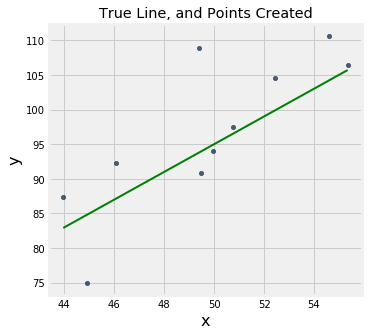

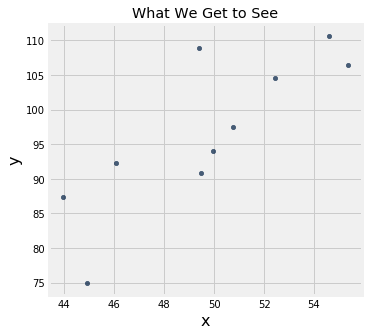

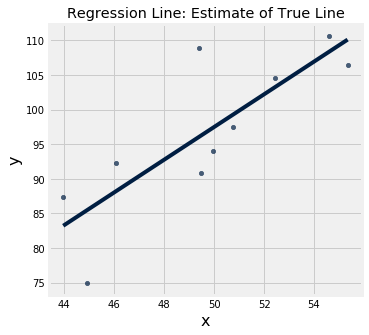

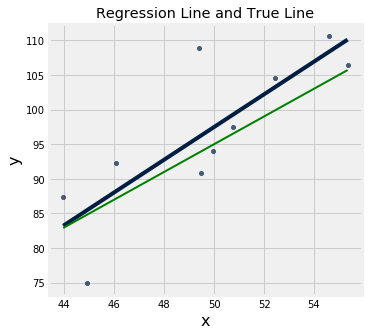

In [27]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter(0, 1)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter(0, 1)
    plots.title('What We Get to See')

    sample.scatter(0, 1, fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter(0, 1, fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")
    
draw_and_compare(2, -5, 10)

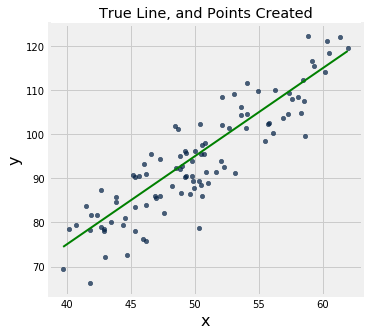

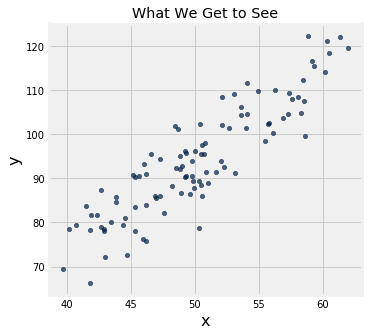

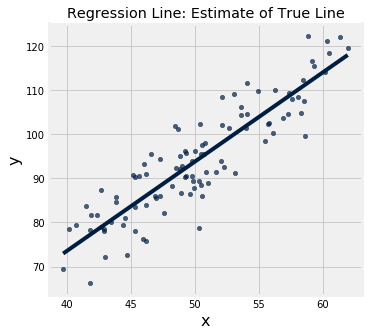

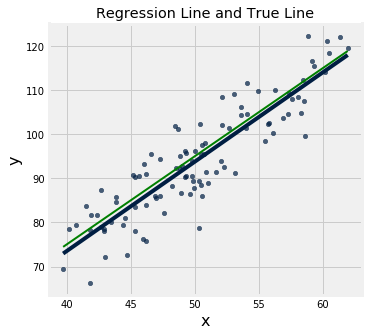

In [28]:
draw_and_compare(2, -5, 100)

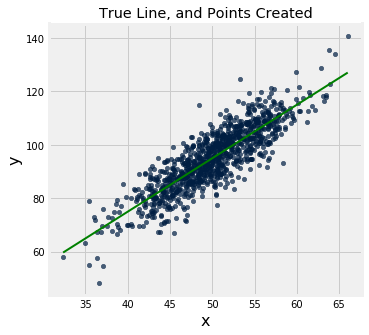

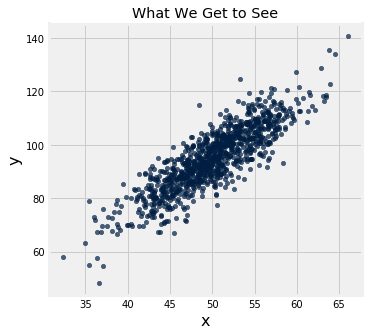

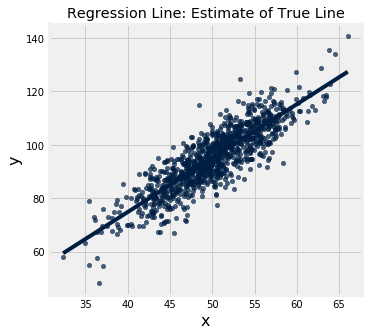

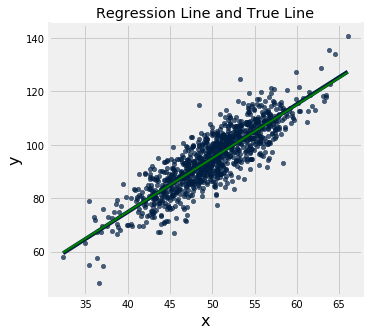

In [24]:
draw_and_compare(2, -5, 1000)

## Slope Inference

In [5]:
baby = Table.read_table('baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


r: 0.407542793389
RMSE: 16.7303582567


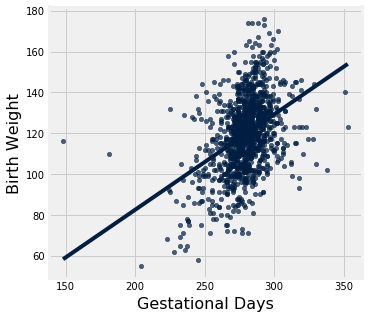

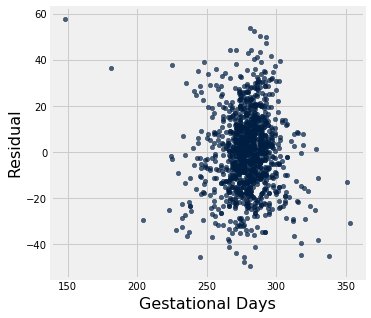

In [29]:
plot_residuals(baby, 1, 0)

In [25]:
slope(baby, 1, 0)

0.46655687694921522

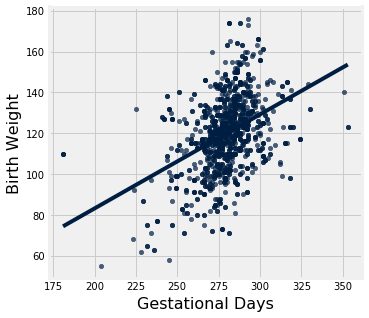

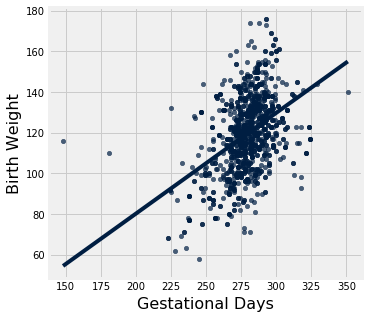

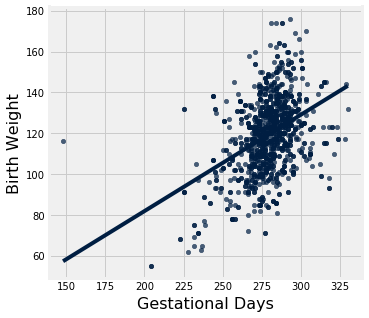

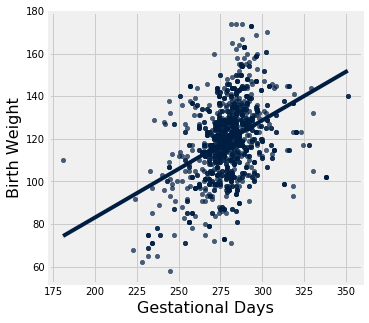

In [26]:
for i in np.arange(4):
    baby.sample().scatter(1, 0, fit_line=True)

In [9]:
baby.num_rows

1174

In [10]:
baby.sample().num_rows

1174

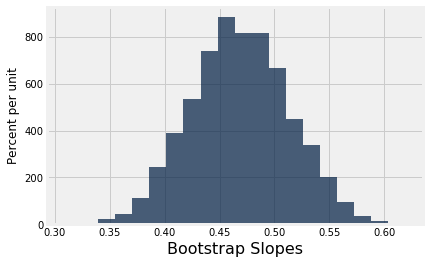

In [11]:
slopes = []
for i in np.arange(5000):
    resample = baby.sample()
    resample_slope = slope(resample, 1, 0)
    slopes.append(resample_slope)
Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)

In [12]:
left = percentile(2.5, slopes)
right = percentile(97.5, slopes)
[left, right]

[0.38292152849037409, 0.55623109193888098]

Slope of regression line: 0.466556876949
Approximate 95%-confidence interval for the true slope:
0.379492527165 0.557408860701


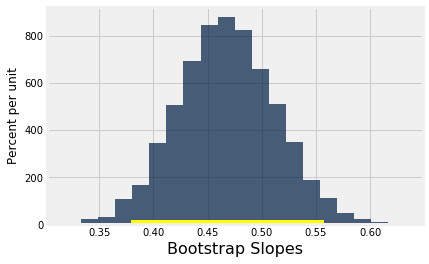

In [30]:
def bootstrap_slope(table, x, y, repetitions=5000):

    # Bootstrap resampling
    slopes = []
    for i in np.arange(5000):
        resample = table.sample()
        resample_slope = slope(resample, x, y)
        slopes.append(resample_slope)

    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)

    # Slope of the regression line from the original sample
    observed_slope = slope(table, x, y)

    # Display results
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Slope of regression line:', observed_slope)
    print('Approximate 95%-confidence interval for the true slope:')
    print(left, right)
    
bootstrap_slope(baby, 1, 0)

r: -0.0534247735078
RMSE: 15.9806300309


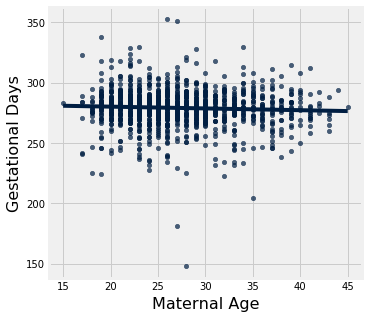

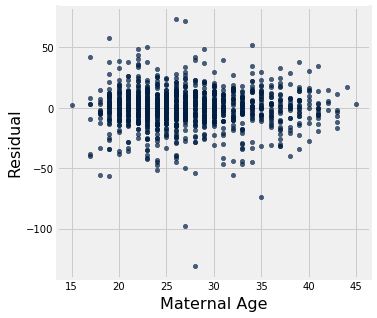

In [13]:
plot_residuals(baby, 2, 1)

Slope of regression line: -0.147021422703
Approximate 95%-confidence interval for the true slope:
-0.301798431657 0.00799856140847


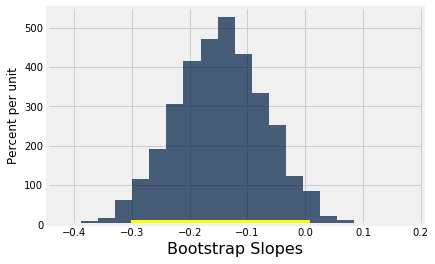

In [16]:
bootstrap_slope(baby, 2, 1)

## Prediction Inference

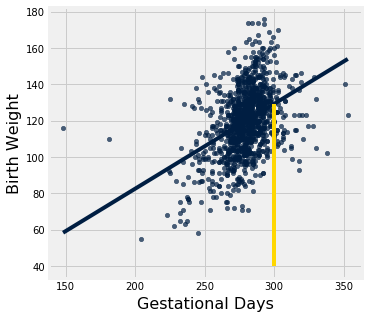

In [17]:
x = 300
a = slope(baby, 1, 0)
b = intercept(baby, 1, 0)
fitted_y = a * x + b
baby.scatter(1, 0, fit_line=True)
plots.plot([x, x], [40, fitted_y], color='gold');

In [18]:
fitted_y

129.2129241703143

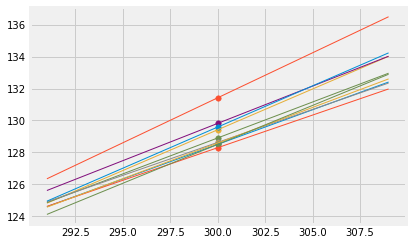

In [19]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = baby.sample()
    a = slope(resample, 1, 0)
    b = intercept(resample, 1, 0)
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30)

Approximate 95%-confidence interval of regression height:
127.20924411 131.321921043 (width = 4.11267693218 )


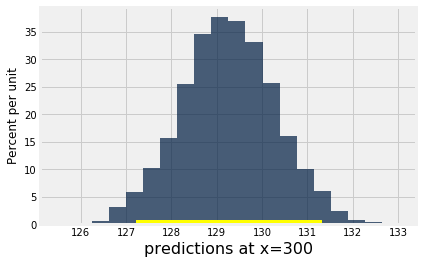

In [20]:
def bootstrap_prediction(table, x, y, new_x, repetitions=5000):

    # Bootstrap resampling
    predictions = []
    for i in np.arange(repetitions):
        resample = table.sample()
        a = slope(resample, x, y)
        b = intercept(resample, x, y)
        fitted_y = a * new_x + b
        predictions.append(fitted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval of regression height:')
    print(left, right, '(width =', right - left, ')')
    
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 300)

Approximate 95%-confidence interval of regression height:
138.766385922 147.972977712 (width = 9.20659179022 )


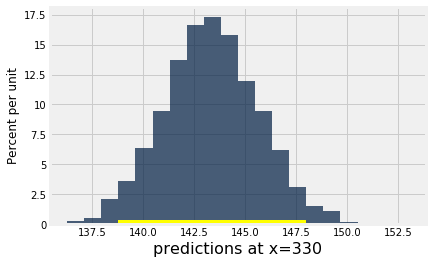

In [21]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 330)

Approximate 95%-confidence interval of regression height:
118.938318407 120.859722215 (width = 1.92140380807 )


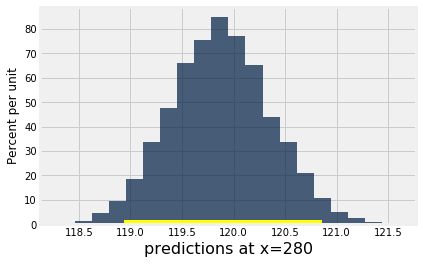

In [22]:
bootstrap_prediction(baby, 'Gestational Days', 'Birth Weight', 280)